In [35]:
import pickle
import chardet
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import markovify
from pprint import pprint
import math
import seaborn as sns
from scipy.stats import gaussian_kde

### Import data

In [3]:
path = './data/beerslaw/features/simplestates_sequences.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)

new_data = {k: v for k, v in data.items() if k != 'available_demographics'}
df = pd.DataFrame.from_dict(new_data, orient='index')

df = df[['idx', 'learner_id', 'gender', 'language', 
         'field', 'year', 'ranking', 'binconcepts', 'binvector', 'sequence']]

actn_seq = [[seq[:4] for seq in d] for d in df['sequence']]
time_seq = [[seq[4:] for seq in d] for d in df['sequence']]

df['actn_seq'] = actn_seq
df['time_seq'] = time_seq

In [4]:
df.head()

,idx,learner_id,gender,language,field,year,ranking,binconcepts,binvector,sequence,actn_seq,time_seq
0,0,svdphyjs,2,Deutsch,Chemistry,1st,2013,1,5,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.99...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.0, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0]..."
1,1,2ae6q3hw,1,Deutsch,"Chemistry, Textiles",3rd,2031,1,7,"[[0.0, 0.0, 0.0, 1.0, 0.002131865576185149, 0....","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.002131865576185149, 0.0, 0.0, 0.0, 0.0, 0...."
2,2,8jp62suc,2,Deutsch,Chemistry,2nd,2013,1,5,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.16...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.0, 0.0, 0.0, 0.0, 0.16387732685859632, 0.0..."
3,3,e93na59g,2,Deutsch,"Chemistry, Textiles",3rd,2031,1,7,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.51...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.0, 0.0, 0.0, 0.0, 0.5154799773410607, 0.0]..."
4,4,chm4sr6j,4,Deutsch,Chemistry,3rd,0231,1,4,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.90...","[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...","[[0.0, 0.0, 0.0, 0.0, 0.9043300375042619, 0.0]..."


### Visualize groups

In [53]:
def visualize_single_group(df, keyword):
    value_counts = df[keyword].value_counts()
    plt.figure(figsize=(4, 3)) 
    sns.barplot(x=value_counts.index, y=value_counts.values)

    plt.title('Frequency count of '+keyword)
    plt.xlabel(keyword)
    plt.ylabel('Count')

    #plt.xticks(rotation=45)
    plt.show()

In [54]:
df['binconcepts'].value_counts() #labels

binconcepts
0    139
1    110
Name: count, dtype: int64

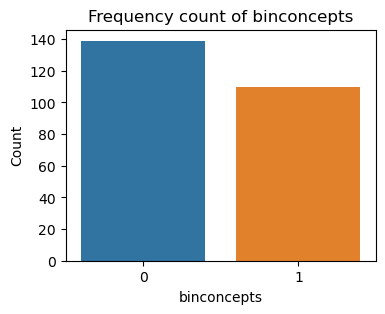

In [55]:
visualize_single_group(df, 'binconcepts')

In [14]:
df['field'].value_counts()

field
Chemistry              160
Chemistry, Textiles     52
Biology                 25
Pharma Chemistry        12
Name: count, dtype: int64

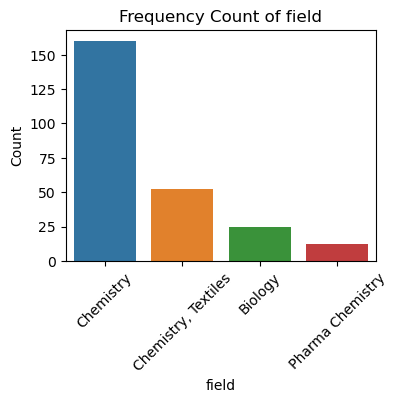

In [30]:
visualize_single_group(df, 'field')

In [15]:
df['year'].value_counts()

year
2nd    108
1st     92
3rd     49
Name: count, dtype: int64

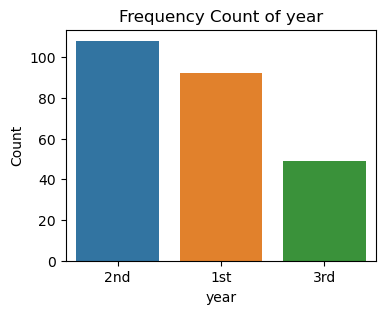

In [33]:
visualize_single_group(df, 'year')

In [16]:
df['language'].value_counts()

language
Deutsch     178
Français     71
Name: count, dtype: int64

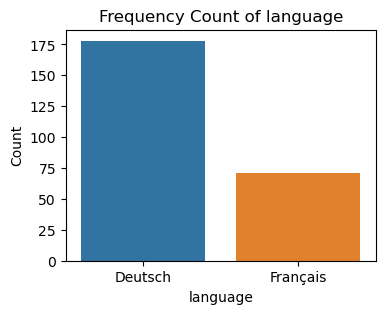

In [34]:
visualize_single_group(df, 'language')

In [51]:
def visualize_combine_group(df, keywords):
    grouped_df = df.groupby(keywords).size().reset_index(name='count')
    grouped_df = grouped_df.reset_index()
    print(type(keywords))
    plt.figure(figsize=(6, 4))
    sns.barplot(x=keywords[0], y='count', hue=keywords[1], data=grouped_df)

    plt.title('Count by ' + keywords[0] + ' and ' + keywords[1])
    plt.xlabel(keywords[0]) 
    plt.ylabel('Count')

    #plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.show()

<class 'list'>


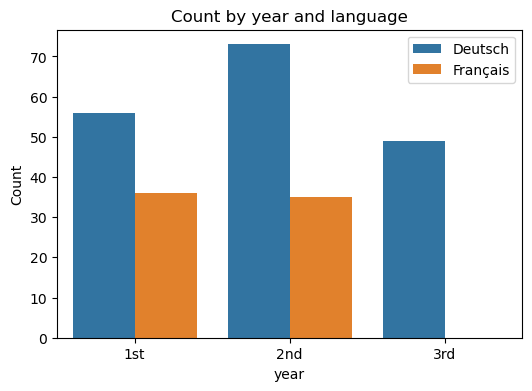

In [52]:
visualize_combine_group(df, ['year','language'])

<class 'list'>


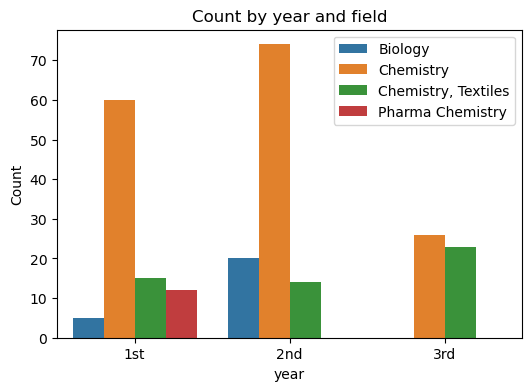

In [56]:
visualize_combine_group(df, ['year','field'])

<class 'list'>


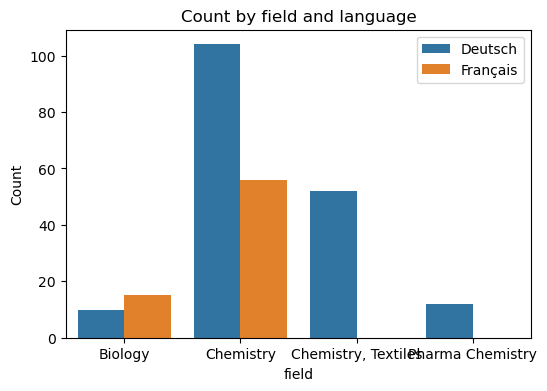

In [57]:
visualize_combine_group(df, ['field','language'])

### Generate Markov chains

In [17]:
def time_seq_to_str(time_seq):
    result = []
    for row in time_seq:
        index = np.argmax(row)
        value = row[index]
        value = math.ceil(value * 10)
        result.append((' '.join([str(index)] * value)).strip())
        #result.append(str(index) * value)
    result_str = ', '.join(result)
    return result_str

In [58]:
def generate_markov_chains(df, groupby_keys, actn_size=4, time_size=4):
    grouped_df = df.groupby(groupby_keys)
    groupby_keys_str = '_'.join(groupby_keys) if isinstance(groupby_keys, list) else groupby_keys
    for keys, group in grouped_df:
        keys = [str(key) for key in keys] if isinstance(keys, tuple) else [str(keys)]
        key_str = '_'.join(keys)
        print(key_str)

        actn_seq = '\n'.join([' '.join(map(str, np.argmax(seq, axis=1))) for seq in group['actn_seq']])
        time_seq = '\n'.join([time_seq_to_str(seq) for seq in group['time_seq']])
        actn_chain = markovify.NewlineText(actn_seq, state_size=actn_size, well_formed=False)
        time_chain = markovify.NewlineText(time_seq, state_size=time_size, well_formed=False)

        for chain_type, chain in zip(['actn', 'time'], [actn_chain, time_chain]):
            chain_json = chain.to_json()
            file_path = f"./data/beerslaw/markov_chains/{'_'.join([groupby_keys_str, key_str, chain_type])}.json"
            os.makedirs(os.path.dirname(file_path), exist_ok=True)

            with open(file_path, 'w') as f:
                json.dump(chain_json, f)



In [60]:
generate_markov_chains(df, ['binconcepts'])

0
1


In [61]:
generate_markov_chains(df, ['field'])

Biology
Chemistry
Chemistry, Textiles
Pharma Chemistry


In [62]:
generate_markov_chains(df, ['language'])

Deutsch
Français


In [63]:
generate_markov_chains(df, ['year'])

1st
2nd
3rd


In [64]:
generate_markov_chains(df, ['field','language'])

Biology_Deutsch
Biology_Français
Chemistry_Deutsch
Chemistry_Français
Chemistry, Textiles_Deutsch
Pharma Chemistry_Deutsch


In [65]:
generate_markov_chains(df, ['year','field'])

1st_Biology
1st_Chemistry
1st_Chemistry, Textiles
1st_Pharma Chemistry
2nd_Biology
2nd_Chemistry
2nd_Chemistry, Textiles
3rd_Chemistry
3rd_Chemistry, Textiles


In [66]:
generate_markov_chains(df, ['year','language'])

1st_Deutsch
1st_Français
2nd_Deutsch
2nd_Français
3rd_Deutsch


### Get sequences length

In [116]:
groupby_keys_list = [['binconcepts'], ['year'], ['field'], ['language'], \
    ['year', 'language'], ['year','field'], ['field','language']]

In [101]:
def calculate_length(df, groupby_keys):
    grouped_df = df.groupby(groupby_keys).apply(get_sequence_length)
    length = grouped_df['length'].reset_index()
    length['groupby_keys'] = str(groupby_keys)  # 添加一列以存储groupby keys
    return length

lengths_df = pd.concat([calculate_length(df, keys) for keys in groupby_keys_list])
lengths_df.to_csv('./data/beerslaw/lengths.csv', index=False)


In [117]:
def read_length_and_sample(file_path, groupby_keys, values):
    lengths_df = pd.read_csv(file_path)
    length_df = lengths_df[lengths_df['groupby_keys'] == str(groupby_keys)]

    for key, value in values.items():
        length_df = length_df[length_df[key] == value]

    length = length_df['length']

    kde = gaussian_kde(length)
    possible_lengths = np.arange(min(length), max(length)+1)
    probabilities = kde.evaluate(possible_lengths)

    sampled_length = np.random.choice(possible_lengths, p=probabilities/probabilities.sum())

    print("Sampled Length:", sampled_length)
    return sampled_length


In [123]:
groupby_keys = ['binconcepts']
seq_label = 0
length_path = './data/beerslaw/lengths.csv'
sampled_length = read_length_and_sample(length_path, groupby_keys, {groupby_keys[0]:seq_label})


Sampled Length: 71
